In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub


In [2]:
path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

print("Dataset path:", path)

DATASET_PATH = f"{path}/data science bowl 2018/stage1_train 2"


Dataset path: /kaggle/input/data-science-bowl-2018-competition-merged-mask


In [3]:
def build_merged_mask(mask_dir, shape):
    merged = np.zeros(shape, dtype=np.uint8)
    for file in os.listdir(mask_dir):
        m = cv2.imread(os.path.join(mask_dir, file), 0)
        if m is not None:
            merged = np.maximum(merged, m)
    return (merged > 0).astype(np.uint8)


In [4]:
def watershed_no_markers(distance, mask):
    labels = watershed(-distance, mask=mask)
    return labels


In [5]:
def watershed_with_markers(distance, mask, min_distance=8):
    coords = peak_local_max(distance, min_distance=min_distance, labels=mask)

    markers = np.zeros(distance.shape, dtype=int)
    for i, (r, c) in enumerate(coords):
        markers[r, c] = i + 1

    labels = watershed(-distance, markers, mask=mask)
    return labels



Showing image 1
Ground truth nuclei: 10
Naive watershed nuclei: 13


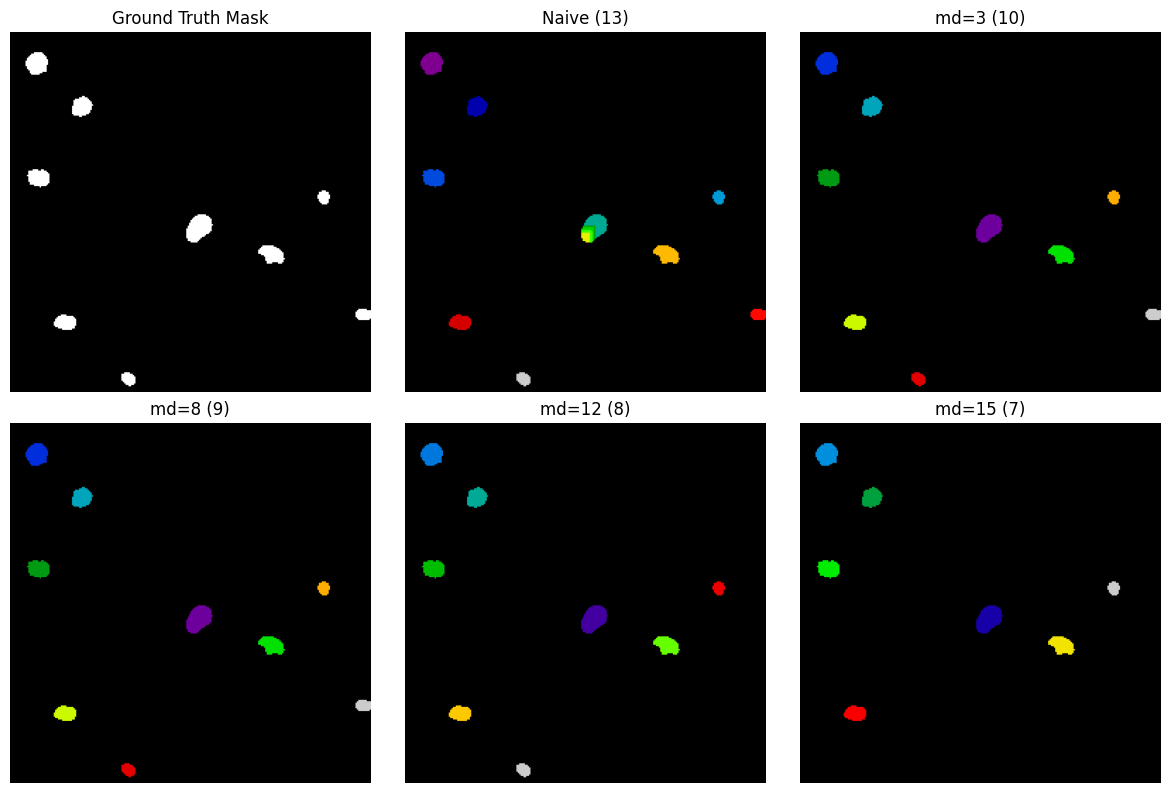


Showing image 2
Ground truth nuclei: 24
Naive watershed nuclei: 31


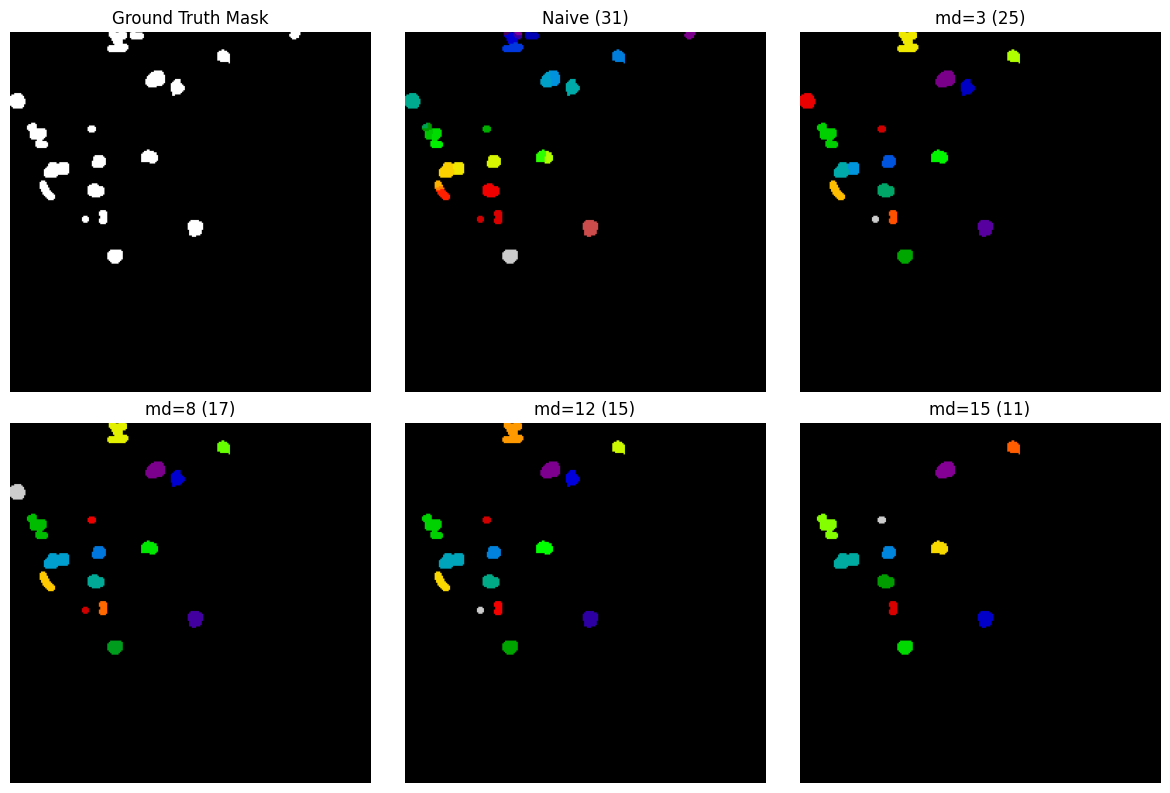


Showing image 3
Ground truth nuclei: 10
Naive watershed nuclei: 13


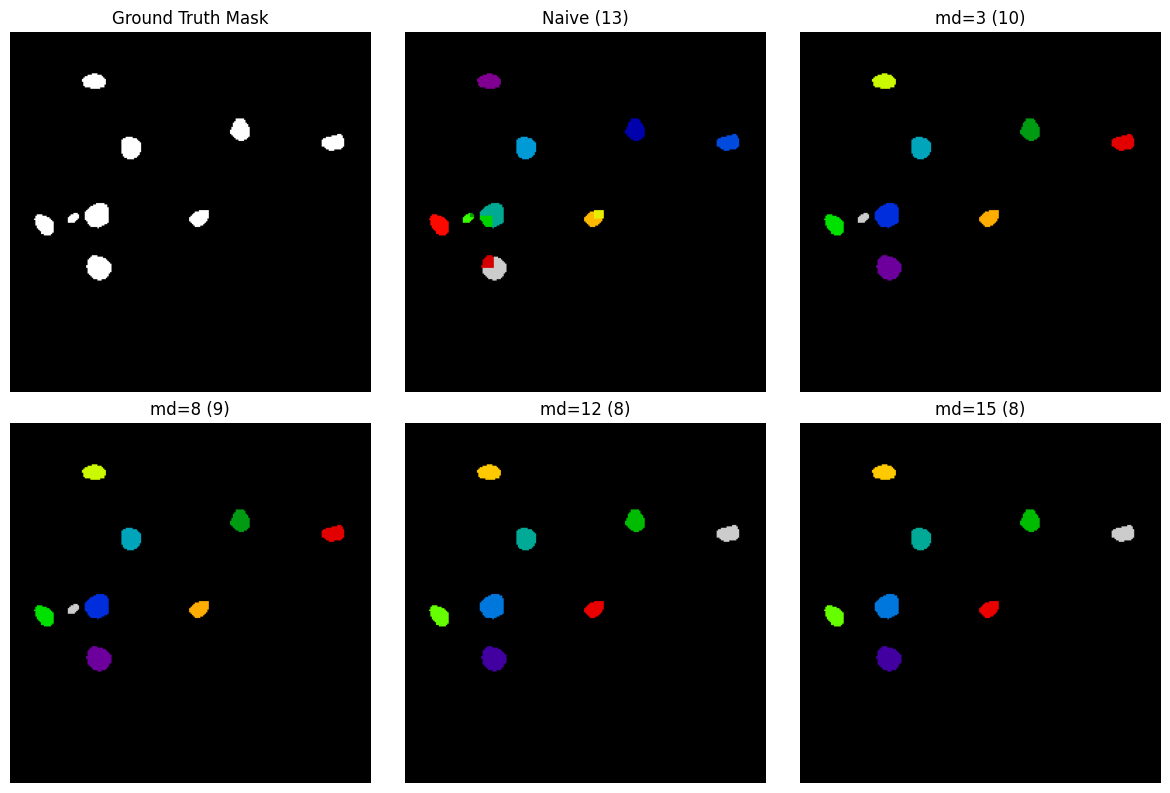


Showing image 4
Ground truth nuclei: 5
Naive watershed nuclei: 6


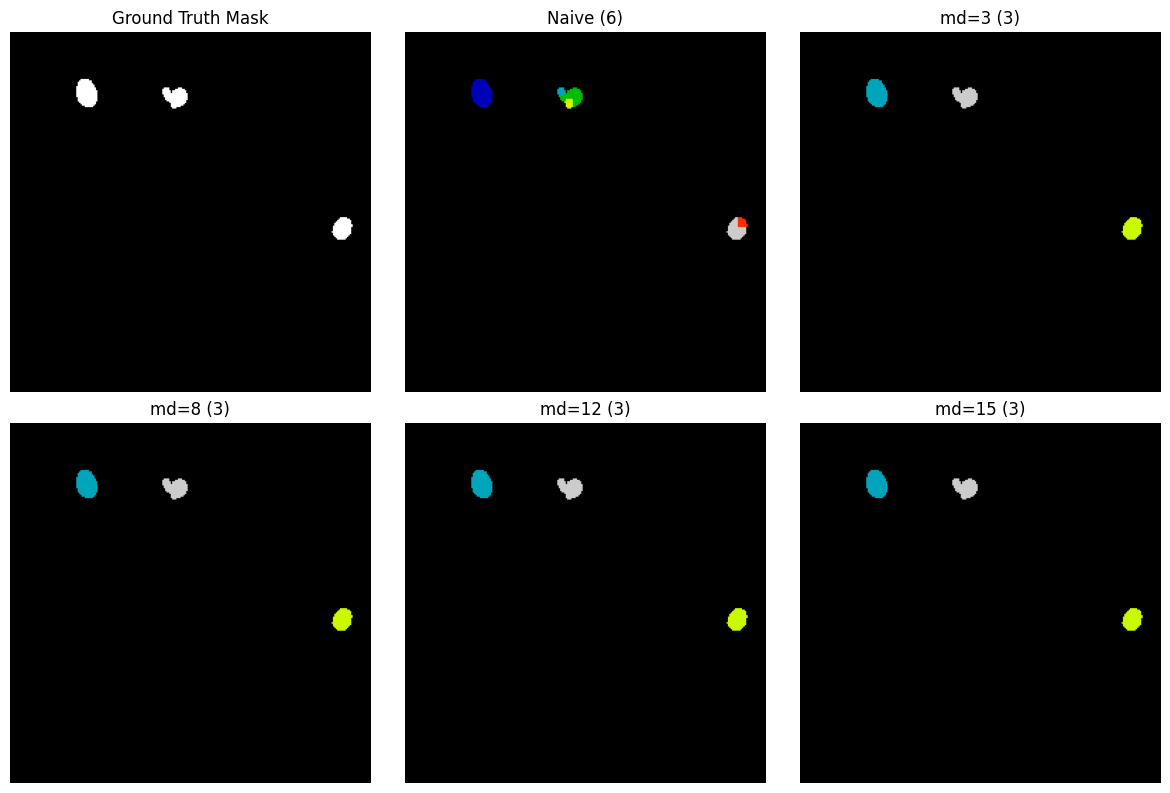


Showing image 5
Ground truth nuclei: 13
Naive watershed nuclei: 17


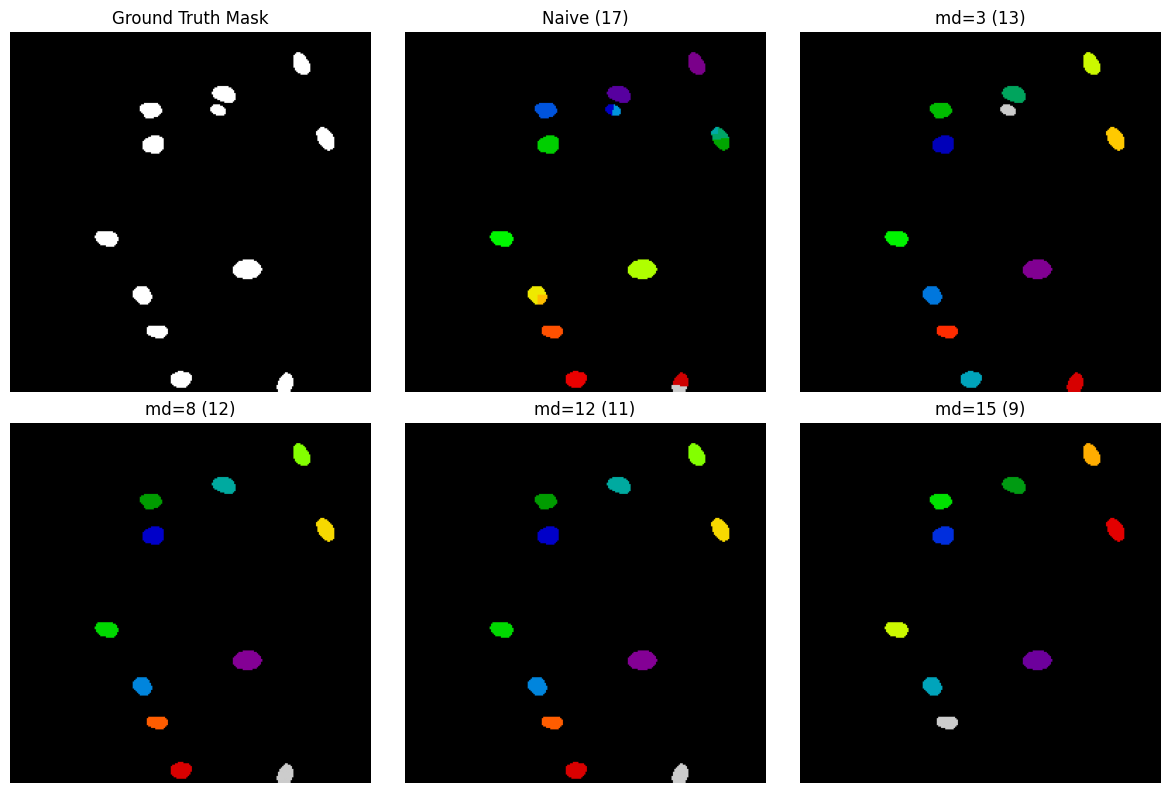


Showing image 6
Ground truth nuclei: 21
Naive watershed nuclei: 126


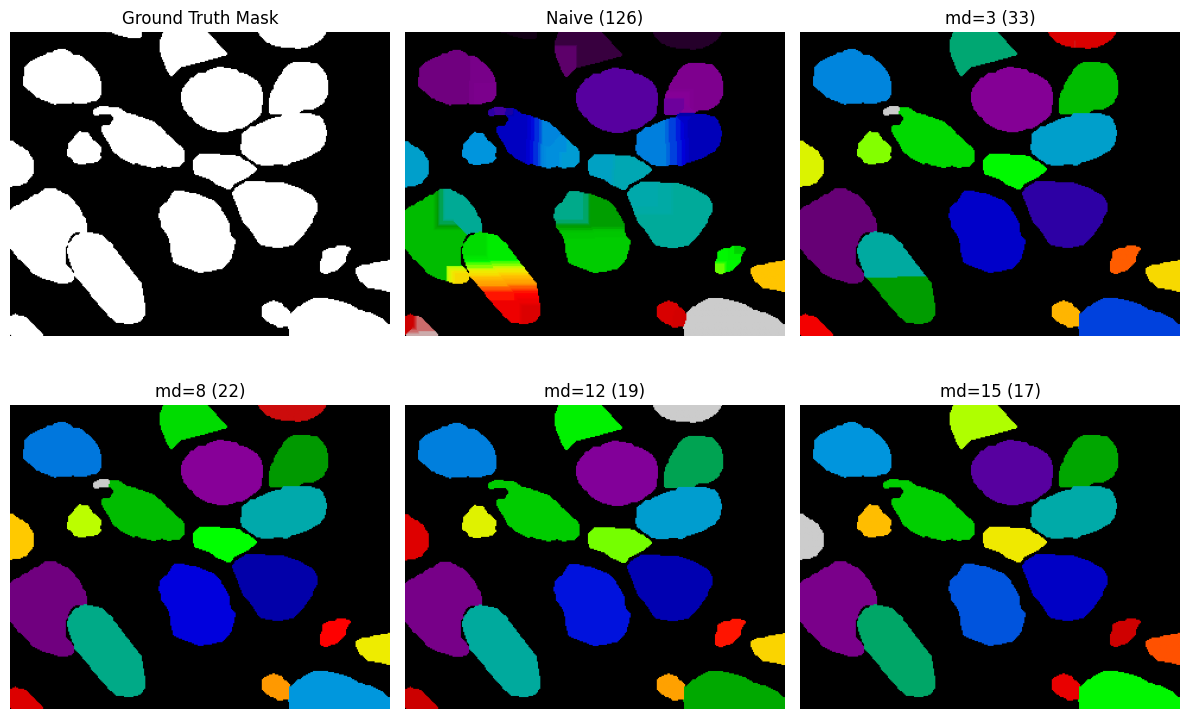


Showing image 7
Ground truth nuclei: 38
Naive watershed nuclei: 62


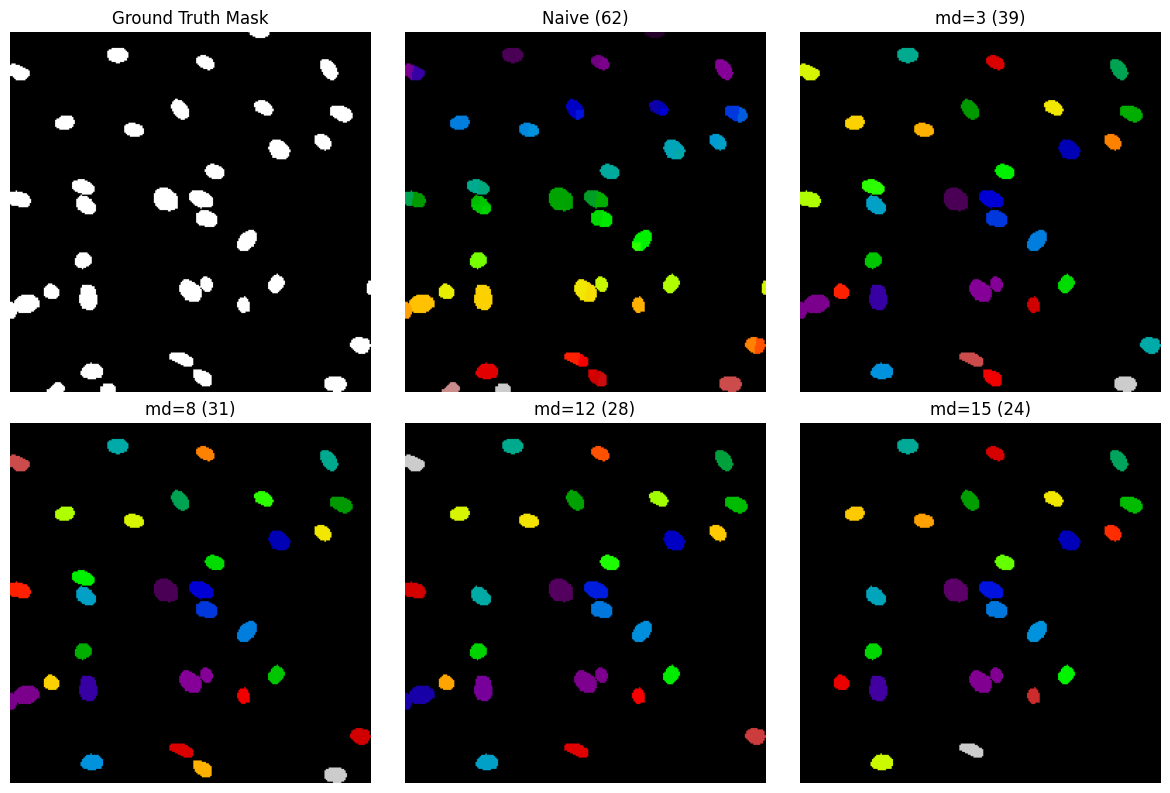


Showing image 8
Ground truth nuclei: 84
Naive watershed nuclei: 353


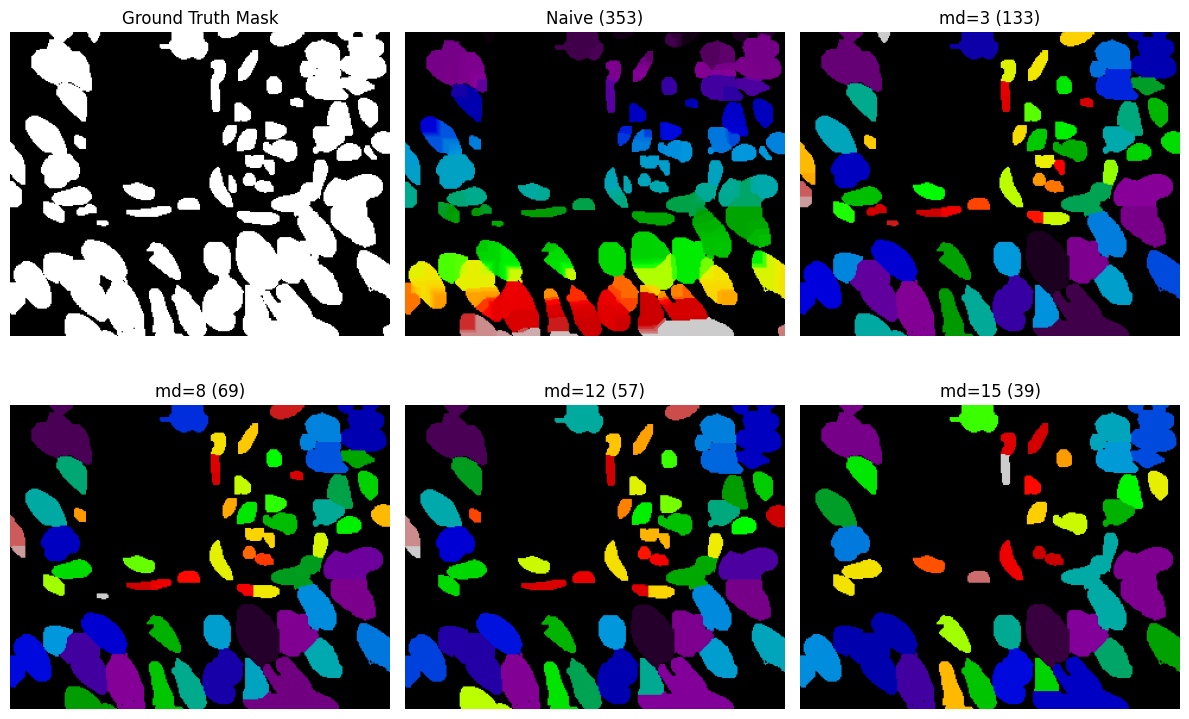


Showing image 9
Ground truth nuclei: 21
Naive watershed nuclei: 126


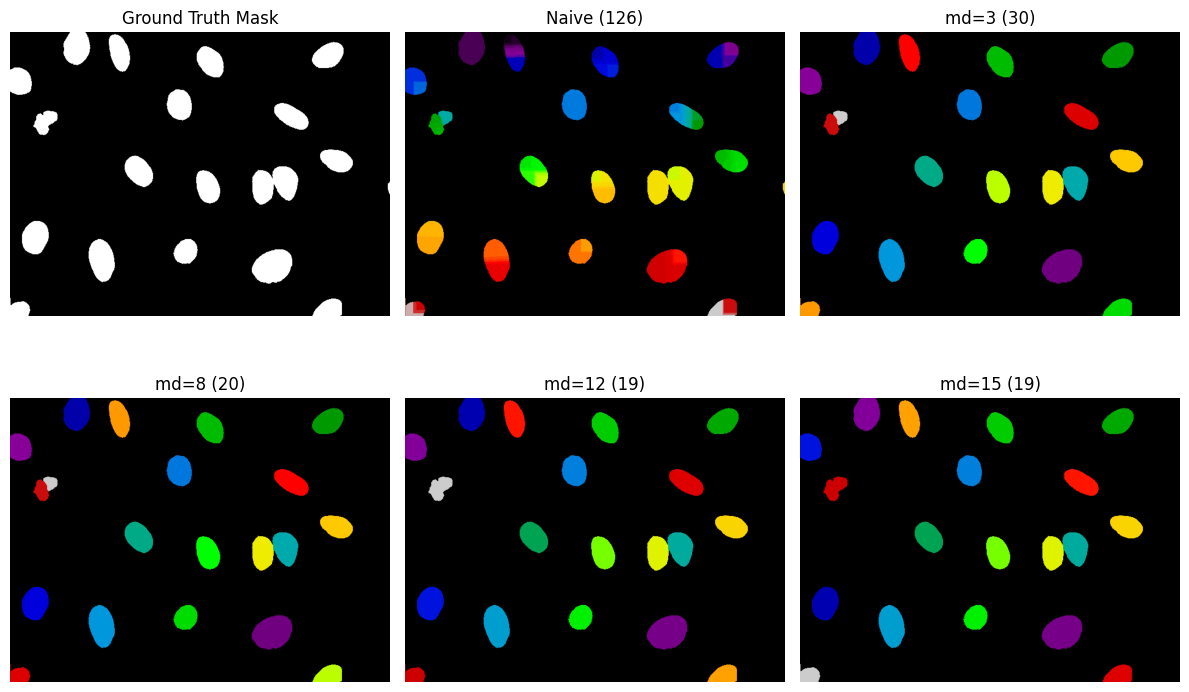


Showing image 10
Ground truth nuclei: 3
Naive watershed nuclei: 4


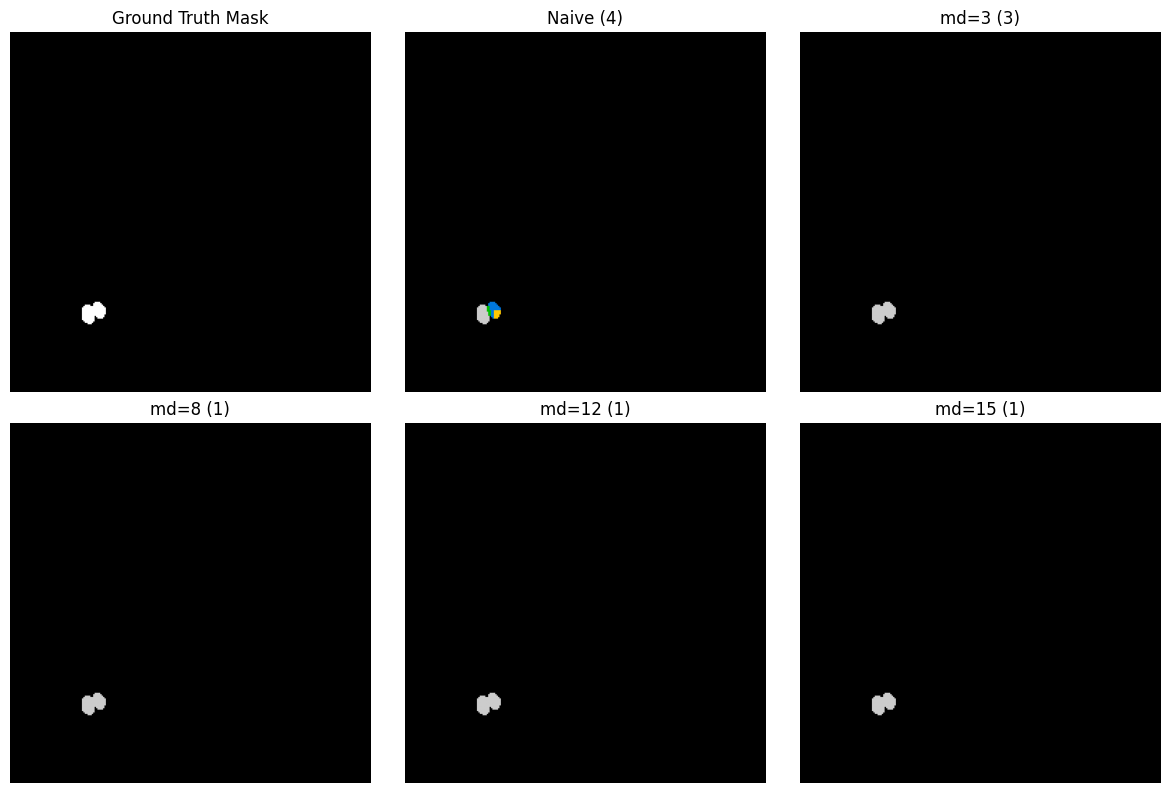

In [9]:
MAX_IMAGES = 10
count = 0

for folder in os.listdir(DATASET_PATH):

    if count >= MAX_IMAGES:
        break

    sample_path = os.path.join(DATASET_PATH, folder)
    img_dir = os.path.join(sample_path, "images")
    mask_dir = os.path.join(sample_path, "masks")

    img_file = os.listdir(img_dir)[0]
    image = cv2.imread(os.path.join(img_dir, img_file))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    merged_mask = build_merged_mask(mask_dir, gray.shape)

    gt_count = len(os.listdir(mask_dir))

    print(f"\nShowing image {count+1}")
    print("Ground truth nuclei:", gt_count)

    distance = distance_transform_edt(merged_mask)

    naive_labels = watershed_no_markers(distance, merged_mask)
    print("Naive watershed nuclei:", naive_labels.max())

    marker_distances = [2, 3, 5, 8, 10, 12, 15]
    results = {}

    for md in marker_distances:
        results[md] = watershed_with_markers(distance, merged_mask, md)

    plt.figure(figsize=(12,8))

    plt.subplot(2,3,1)
    plt.title(f"Ground Truth Mask")
    plt.imshow(merged_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(2,3,2)
    plt.title(f"Naive ({naive_labels.max()})")
    plt.imshow(naive_labels, cmap='nipy_spectral')
    plt.axis("off")

    plt.subplot(2,3,3)
    plt.title(f"md=3 ({results[3].max()})")
    plt.imshow(results[3], cmap='nipy_spectral')
    plt.axis("off")
    
    plt.subplot(2,3,3)
    plt.title(f"md=3 ({results[3].max()})")
    plt.imshow(results[5], cmap='nipy_spectral')
    plt.axis("off")

    plt.subplot(2,3,3)
    plt.title(f"md=3 ({results[3].max()})")
    plt.imshow(results[8], cmap='nipy_spectral')
    plt.axis("off")

    plt.subplot(2,3,4)
    plt.title(f"md=8 ({results[8].max()})")
    plt.imshow(results[10], cmap='nipy_spectral')
    plt.axis("off")

    plt.subplot(2,3,5)
    plt.title(f"md=12 ({results[12].max()})")
    plt.imshow(results[12], cmap='nipy_spectral')
    plt.axis("off")

    plt.subplot(2,3,6)
    plt.title(f"md=15 ({results[15].max()})")
    plt.imshow(results[15], cmap='nipy_spectral')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    count += 1


Naive watershed operates without prior knowledge of object centers and floods from all minima, often leading to unstable segmentation. Marker-controlled watershed introduces seed points derived from the distance transform, enabling controlled flooding and significantly improving the separation of touching nuclei.